In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils import class_weight

from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Own code
import import_ipynb
import metadata_options
import models_semantic
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_semantic.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


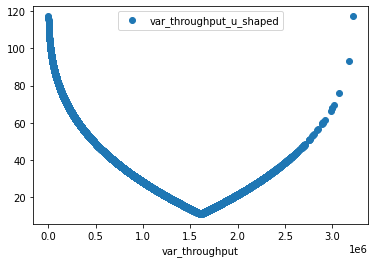

In [3]:
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: randomforest, logreg

model_name = 'svc'
models_semantic.MODEL_NAME = model_name

SVC = SVC()

def get_semantic_model():
    return SVC

In [5]:
df = df.drop(columns=['Input.msg_id', 'HITId', 'Input.sentence_id', 'Input.convo_id', 'Input.train_test_val',
                     'Input.similar_text_id', 'Input.msg_id', 'Input.timestamp', 'Input.full_text',
                      'Input.speaker', 'Input.reply_to', 
                      'Input.game_score_delta', 'Input.game_score_receiver',
                      'Input.speaker_intention', 'Input.reciever_perception', 'Input.reciever',
                      'Input.absolute_message_index', 'Input.relative_message_index', 'Input.year',
                      'Input.game_score_speaker', 'Input.num_words', 'Input.num_characters', 
                      'Input.sno', 'Input.sno1',
                      'WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5',
                      'Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5',
                      'Answer.1gamemove.yes', 'Answer.2reasoning.yes',
                      'Answer.3a_apologies.yes', 'Answer.3a_compliment.yes', 'Answer.3a_personalthoughts.yes',
                      'Answer.3a_reassurance.yes', 'Answer.3rapport.yes', 'Answer.4shareinformation.yes', 'count',
                      'Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 
                      'Answer.3a_apologies.yes_pc_agree', 'Answer.3a_compliment.yes_pc_agree',
                      'Answer.3a_personalthoughts.yes_pc_agree', 'Answer.3a_reassurance.yes_pc_agree',
                      'Answer.3rapport.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 
                      'message_id.x', 'message_id.y',
                      'Answer.3a_apologies.yes_label', 'Answer.3a_compliment.yes_label',
                      'Answer.3a_personalthoughts.yes_label', 'Answer.3a_reassurance.yes_label'
                     ])

In [6]:
indices = range(df.shape[0])

In [7]:
# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_train = train.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

X_test = test.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

In [8]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [9]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


### Individual classifiers are ML models

In [10]:
# Game move classifier
clf_gamemove = get_semantic_model()
clf_gamemove.fit(X_train, y_train_gamemove)
y_pred_gamemove = clf_gamemove.predict(X_train)
y_pred_test_gamemove = clf_gamemove.predict(X_test)
print(classification_report(y_pred_gamemove, y_train_gamemove))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.93      0.96      9092

    accuracy                           0.93      9092
   macro avg       0.50      0.46      0.48      9092
weighted avg       1.00      0.93      0.96      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Rapport classifier
clf_rapport = get_semantic_model()
clf_rapport.fit(X_train, y_train_rapport)
y_pred_rapport = clf_rapport.predict(X_train)
y_pred_test_rapport = clf_rapport.predict(X_test)
print(classification_report(y_pred_rapport, y_train_rapport))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.86      0.92      9092

    accuracy                           0.86      9092
   macro avg       0.50      0.43      0.46      9092
weighted avg       1.00      0.86      0.92      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Share Information classifier
clf_shareinfo = get_semantic_model()
clf_shareinfo.fit(X_train, y_train_share_information)
y_pred_shareinfo = clf_shareinfo.predict(X_train)
y_pred_test_shareinfo = clf_shareinfo.predict(X_test)
print(classification_report(y_pred_shareinfo, y_train_share_information))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.84      0.91      9092

    accuracy                           0.84      9092
   macro avg       0.50      0.42      0.46      9092
weighted avg       1.00      0.84      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Reasoning classifier
clf_reasoning = get_semantic_model()
clf_reasoning.fit(X_train, y_train_reasoning)
y_pred_reasoning = clf_reasoning.predict(X_train)
y_pred_test_reasoning = clf_reasoning.predict(X_test)
print(classification_report(y_pred_reasoning, y_train_reasoning))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91      9092

    accuracy                           0.83      9092
   macro avg       0.50      0.42      0.45      9092
weighted avg       1.00      0.83      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
uni, cnt = np.unique(y_pred_gamemove, return_counts=True)
print(uni, cnt)

[1.] [9092]


In [15]:
# Deception classifier
clf_deception = get_semantic_model()
clf_deception.fit(X_train, y_train_deception)
y_pred_deception = clf_reasoning.predict(X_train)
y_pred_test_deception = clf_deception.predict(X_test)
print(classification_report(y_pred_deception, y_train_deception))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      9092

    accuracy                           0.95      9092
   macro avg       0.50      0.48      0.49      9092
weighted avg       1.00      0.95      0.97      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### One hot encodings 

In [16]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(y_pred_gamemove)):  
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_shareinfo[i]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_rapport[i]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [17]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(y_pred_test_gamemove)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_test_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_test_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_test_shareinfo[i]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_test_rapport[i]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

In [18]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values = df_throughput[df_throughput_keys[-1]].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values = df_worktime[df_worktime_keys[-1]].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values = df_agreement[df_agreement_keys[-1]].take(indices_train).values
    pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values, axis=0)
    pred_df_agreement = pred_df_throughput.mul(agreement_values, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values = df_agreement.take(indices_train)
    pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
    agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)
    
textlength_values = df_textlength.take(indices_train).values
pred_df_full_textlength = pred_df_full_throughput.mul(textlength_values, axis=0)
pred_df_textlength = pred_df_throughput.mul(textlength_values, axis=0)

df_special_keys = df_special.keys().to_list()
special_values = df_special[df_special_keys[-1]].take(indices_train).values
pred_df_full_special = pred_df_full_throughput.mul(special_values, axis=0)
pred_df_special = pred_df_throughput.mul(special_values, axis=0)

In [19]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values_test = df_throughput[df_throughput_keys[-1]].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values_test = df_worktime[df_worktime_keys[-1]].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values_test = df_agreement[df_agreement_keys[-1]].take(indices_test).values
    pred_df_full_agreement_test = pred_df_full_throughput_test.mul(agreement_values_test, axis=0)
    pred_df_agreement_test = pred_df_throughput_test.mul(agreement_values_test, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values_test = df_agreement.take(indices_test)
    pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
    agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)
    
textlength_values_test = df_textlength.take(indices_test).values
pred_df_full_textlength_test = pred_df_full_throughput_test.mul(textlength_values_test, axis=0)
pred_df_textlength_test = pred_df_throughput_test.mul(textlength_values_test, axis=0)

df_special_keys = df_special.keys().to_list()
special_values_test = df_special[df_special_keys[-1]].take(indices_test).values
pred_df_full_special_test = pred_df_full_throughput_test.mul(special_values_test, axis=0)
pred_df_special_test = pred_df_throughput_test.mul(special_values_test, axis=0)

### Joint model is dense layer

In [20]:
y_train_deception = np.array(y_train_deception)
y_test_deception = np.array(y_test_deception)

y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

In [21]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception),
                    class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.1542 - f1_m: 0.1151 - precision_m: 0.1117 - recall_m: 0.1189 - val_loss: 0.6935 - val_acc: 0.0493 - val_f

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.0491 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6940 - val_acc: 0.0493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 28/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9059 - f1_m: 0.9269 - precision_m: 0.9044 - recall_m: 0.9510 - val_loss: 0.6922 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6610 - f1_m: 0.6670 - precision_m: 0.6499 - recall_m: 0.6853 - val_loss: 0.6923 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6560 - f1_m: 0.6605 - precision_m: 0.6439 - recall_m: 0.6783 - val_loss: 0.6911 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_pre

In [22]:
full_pred = joint_full_model.predict(pred_df_full)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model.predict(pred_test_df_full)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

In [23]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [24]:
precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [25]:
y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

print('Joint full model with one hot encoding, predicting rapport')
joint_full_model_rapport = models_nn.create_joint_model(pred_df)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.8604 - f1_m: 0.9250 - precision_m: 0.8613 - recall_m: 1.0000 - val_loss: 0.6913 - val_acc: 0.8712 - val_f1_

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.2496 - f1_m: 0.1466 - precision_m: 0.1351 - recall_m: 0.1608 - val_loss: 0.6940 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.1396 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6960 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.1396 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6952 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4810 - f1_m: 0.4384 - precision_m: 0.4073 - recall_m: 0.4755 - val_loss: 0.6934 - val_acc:

In [26]:
full_pred = joint_full_model_rapport.predict(pred_df)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model_rapport.predict(pred_test_df)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [27]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [28]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6967 - acc: 0.1523 - f1_m: 0.1882 - precision_m: 0.5770 - recall_m: 0.1174 - val_loss: 0.7209 -

Epoch 29/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.8800 - f1_m: 0.8994 - precision_m: 0.8778 - recall_m: 0.9225 - val_loss: 0.6924 - val_acc: 0.9499 - val_f1_m: 0.9740 - val_precision_m: 0.9506 - val_recall_m: 0.9991
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4496 - f1_m: 0.4406 - precision_m: 0.4280 - recall_m: 0.4543 - val_loss: 0.6917 - val_acc: 0.9499 - val_f1_m: 0.9740 - val_precision_m: 0.9506 - val_recall_m: 0.9991
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5796 - f1_m: 0.5717 - precision_m: 0.5574 - recall_m: 0.5872 - val_loss: 0.6935 - val_acc: 0.0493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.0491 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6946 - val_acc: 0.0493 - val_f1_m: 0.00

In [29]:
full_pred = joint_full_model.predict(pred_df_full)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model.predict(pred_test_df_full)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [30]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0.] [2274]


In [31]:
y_train_rapport = np.array(y_train_rapport).astype(int)
y_test_rapport = np.array(y_test_rapport).astype(int)

In [32]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model_rapport = models_nn.create_joint_model(pred_df_throughput)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6942 - acc: 0.2512 - f1_m: 0.2162 - precision_m: 0.4506 - recall_m: 0.1652 - val_loss: 0.7034 - v

143/143 [==============================] - 0s 3ms/step - loss: 0.6624 - acc: 0.5119 - f1_m: 0.6235 - precision_m: 0.9150 - recall_m: 0.4768 - val_loss: 0.6806 - val_acc: 0.5070 - val_f1_m: 0.6201 - val_precision_m: 0.9252 - val_recall_m: 0.4693
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6622 - acc: 0.5074 - f1_m: 0.6193 - precision_m: 0.9136 - recall_m: 0.4722 - val_loss: 0.6886 - val_acc: 0.4903 - val_f1_m: 0.6004 - val_precision_m: 0.9259 - val_recall_m: 0.4478
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6619 - acc: 0.4902 - f1_m: 0.6003 - precision_m: 0.9178 - recall_m: 0.4501 - val_loss: 0.6533 - val_acc: 0.5695 - val_f1_m: 0.6872 - val_precision_m: 0.9190 - val_recall_m: 0.5512
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6621 - acc: 0.5121 - f1_m: 0.6252 - precision_m: 0.9146 - recall_m: 0.4830 - val_loss: 0.6493 - val_acc: 0.5752 - val_f1_m: 0.6932 - val_precision_m: 0.9179 - val_r

In [33]:
full_pred_test = joint_full_model_rapport.predict(pred_df_throughput_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

(0.5525468817092422, 0.6165914067601257, 0.49334729500332125, None)

In [34]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0. 1.] [1067 1207]


In [35]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_worktime_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.4131 - f1_m: 0.4011 - precision_m: 0.3904 - recall_m: 0.4126 - val_loss: 0.6925 - 

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6914 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4096 - f1_m: 0.3950 - precision_m: 0.3852 - recall_m: 0.4056 - val_loss: 0.6919 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9509 - f1_m: 0.9749 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6900 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6175 - f1_m: 0.6173 - precision_m: 0.6005 - recall_m: 0.6364 - val_loss: 0.6912 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_worktime_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6949 - acc: 0.6802 - f1_m: 0.7371 - precision_m: 0.8662 - recall_m: 0.7524 - val_loss: 0.6897 - va

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.8246 - f1_m: 0.9027 - precision_m: 0.8635 - recall_m: 0.9473 - val_loss: 0.6909 - val_acc: 0.8360 - val_f1_m: 0.9086 - val_precision_m: 0.8697 - val_recall_m: 0.9527
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6919 - acc: 0.8240 - f1_m: 0.9024 - precision_m: 0.8637 - recall_m: 0.9465 - val_loss: 0.6905 - val_acc: 0.8369 - val_f1_m: 0.9091 - val_precision_m: 0.8698 - val_recall_m: 0.9537
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.8234 - f1_m: 0.9012 - precision_m: 0.8617 - recall_m: 0.9459 - val_loss: 0.6901 - val_acc: 0.8360 - val_f1_m: 0.9088 - val_precision_m: 0.8687 - val_recall_m: 0.9542
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.8251 - f1_m: 0.9031 - precision_m: 0.8632 - recall_m: 0.9485 - val_loss: 0.6911 - val_acc: 0.8351 - val_f1_m: 0.9081 - val_precision_m: 0.

In [37]:
print('Joint full model with one hot encoding, predicting deception, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_agreement_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by agreement
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6942 - acc: 0.2678 - f1_m: 0.3621 - precision_m: 0.9262 - recall_m: 0.2432 - val_loss: 0.6982 -

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8006 - f1_m: 0.8335 - precision_m: 0.8301 - recall_m: 0.8377 - val_loss: 0.6931 - val_acc: 0.9279 - val_f1_m: 0.9622 - val_precision_m: 0.9539 - val_recall_m: 0.9712
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6619 - f1_m: 0.6839 - precision_m: 0.6838 - recall_m: 0.6847 - val_loss: 0.6932 - val_acc: 0.9033 - val_f1_m: 0.9486 - val_precision_m: 0.9533 - val_recall_m: 0.9449
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.2624 - f1_m: 0.2376 - precision_m: 0.2383 - recall_m: 0.2373 - val_loss: 0.6935 - val_acc: 0.9261 - val_f1_m: 0.9612 - val_precision_m: 0.9538 - val_recall_m: 0.9694
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.9232 - f1_m: 0.9599 - precision_m: 0.9515 - recall_m: 0.9691 - val_loss: 0.6912 - val_acc: 0.9323 - val_f1_m: 0.9645 - val_precision_m: 0.

In [38]:
print('Joint full model with one hot encoding, predicting rapport, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_agreement_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by agreement
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6953 - acc: 0.1654 - f1_m: 0.0502 - precision_m: 0.1603 - recall_m: 0.0360 - val_loss: 0.6887 - v

143/143 [==============================] - 0s 3ms/step - loss: 0.5798 - acc: 0.6760 - f1_m: 0.7793 - precision_m: 0.9341 - recall_m: 0.6716 - val_loss: 0.5869 - val_acc: 0.6636 - val_f1_m: 0.7692 - val_precision_m: 0.9397 - val_recall_m: 0.6531
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.5794 - acc: 0.6638 - f1_m: 0.7673 - precision_m: 0.9373 - recall_m: 0.6526 - val_loss: 0.5709 - val_acc: 0.6728 - val_f1_m: 0.7771 - val_precision_m: 0.9394 - val_recall_m: 0.6646
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.5792 - acc: 0.6721 - f1_m: 0.7758 - precision_m: 0.9367 - recall_m: 0.6650 - val_loss: 0.5777 - val_acc: 0.6697 - val_f1_m: 0.7745 - val_precision_m: 0.9396 - val_recall_m: 0.6606
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.5790 - acc: 0.6682 - f1_m: 0.7718 - precision_m: 0.9357 - recall_m: 0.6596 - val_loss: 0.5781 - val_acc: 0.6680 - val_f1_m: 0.7732 - val_precision_m: 0.9389 - val_r

In [39]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength_test)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_textlength_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_textlength_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.5312 - f1_m: 0.5945 - precision_m: 0.8281 - recall_m: 0.5399 - val_loss: 0.6933

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8525 - f1_m: 0.8975 - precision_m: 0.9113 - recall_m: 0.8925 - val_loss: 0.6907 - val_acc: 0.9490 - val_f1_m: 0.9736 - val_precision_m: 0.9506 - val_recall_m: 0.9982
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4076 - f1_m: 0.4034 - precision_m: 0.4043 - recall_m: 0.4052 - val_loss: 0.6893 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9500 - f1_m: 0.9744 - precision_m: 0.9512 - recall_m: 0.9990 - val_loss: 0.6897 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9291 - f1_m: 0.9619 - precision_m: 0.9493 - recall_m: 0.9765 - val_loss: 0.6902 - val_acc: 0.9490 - val_f1_m: 0.9736 - val_precision_m: 0.9506 - val_r

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_textlength_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_textlength_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6885 - acc: 0.8288 - f1_m: 0.9016 - precision_m: 0.8669 - recall_m: 0.9493 - val_loss: 0.6743 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6698 - acc: 0.5150 - f1_m: 0.6238 - precision_m: 0.9036 - recall_m: 0.4800 - val_loss: 0.6774 - val_acc: 0.4763 - val_f1_m: 0.5884 - val_precision_m: 0.9205 - val_recall_m: 0.4352
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6702 - acc: 0.4842 - f1_m: 0.5922 - precision_m: 0.9183 - recall_m: 0.4413 - val_loss: 0.6703 - val_acc: 0.4899 - val_f1_m: 0.6045 - val_precision_m: 0.9165 - val_recall_m: 0.4541
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6699 - acc: 0.5007 - f1_m: 0.6076 - precision_m: 0.9097 - recall_m: 0.4595 - val_loss: 0.6669 - val_acc: 0.4960 - val_f1_m: 0.6124 - val_precision_m: 0.9155 - val_recall_m: 0.4632
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6700 - acc: 0.4947 - f1_m: 0.5998 - precision_m: 0.9107 - recall_m: 0.4520 - val_loss: 0.6627 - val_acc: 0.5035 - val_f1_m: 0.6211 - val_precision_m: 0.9144 - val_r

In [41]:
## Joint full model with semantic model, predicting deception
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_full, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full)
y_pred_test_deception = clf_joint.predict(pred_test_df_full)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [42]:
## Joint full model with semantic model, predicting rapport
clf_joint = get_semantic_model()
clf_joint.fit(pred_df, y_train_rapport)
y_pred_repport = clf_joint.predict(pred_df)
y_pred_test_rapport = clf_joint.predict(pred_test_df)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [43]:
## Joint full model with semantic model, predicting deception, weighted by throughput
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_full_throughput, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full_throughput)
y_pred_test_deception = clf_joint.predict(pred_df_full_throughput_test)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [44]:
## Joint full model with semantic model, predicting rapport, weighted by throughput
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_throughput, y_train_rapport)
y_pred_rapport = clf_joint.predict(pred_df_throughput)
y_pred_test_rapport = clf_joint.predict(pred_df_throughput_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [45]:
## Joint full model with semantic model, predicting deception, weighted by worktime
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_full_worktime, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_worktime_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.47537379067722074, 0.4873760144274121, None)

In [46]:
## Joint full model with semantic model, predicting rapport, weighted by worktime
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_worktime, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_worktime_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.4355760773966579, 0.4655699177438308, None)

In [47]:
## Joint full model with semantic model, predicting deception, weighted by agreement
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_full_agreement, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_agreement_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.47537379067722074, 0.4873760144274121, None)

In [48]:
## Joint full model with semantic model, predicting rapport, weighted by agreement
clf_joint = get_semantic_model()
clf_joint.fit(pred_df_agreement, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_agreement_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.4355760773966579, 0.4655699177438308, None)

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

In [49]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
print(precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro'))
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7025 - acc: 0.4079 - f1_m: 0.5585 - precision_m: 0.9494 - recall_m: 0.4003 - val_loss: 0.6

143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6962 - f1_m: 0.7131 - precision_m: 0.9463 - recall_m: 0.7231 - val_loss: 0.6911 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6919 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.7636 - f1_m: 0.7741 - precision_m: 0.9157 - recall_m: 0.7891 - val_loss: 0.6925 - val_acc: 0.0682 - val_f1_m: 0.0431 - val_precision_m: 0.7361 - val_recall_m: 0.0223
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6254 - f1_m: 0.6348 - precision_m: 0.8553 - recall_m: 0.6456 - val_loss: 0.6908 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_r

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
print(precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro'))
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6932 - acc: 0.2859 - f1_m: 0.1923 - precision_m: 0.1776 - recall_m: 0.2098 - val_loss: 0.693